# Get metrics and Plot

In [1]:
import matplotlib.pyplot as plt
from lib.eval import *
from sklearn.metrics import r2_score
import numpy as np
import glob
import os

In [2]:
log_dir = "logs/best"

evaluator = Evaluator(log_dir)

In [4]:
# non_mae, nmae, r = evaluator.get_metrics(evaluator.testloader)

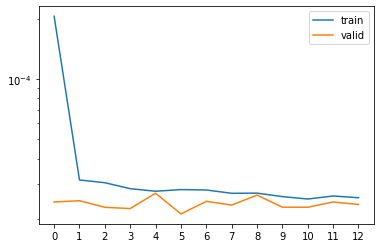

In [4]:
train_values, valid_values = evaluator.get_loss()
plt.plot(train_values, label="train")
plt.plot(valid_values, label="valid")
plt.xticks(np.arange(len(valid_values)))
plt.yscale("log")
plt.legend()
plt.show()

In [15]:
# np.save("../../notebooks/metrics/MAE_SFNP.npy", non_mae)
# np.save("../../notebooks/metrics/r2_SFNP.npy", r)
# np.save("../../notebooks/metrics/NMAE_SFNP.npy", nmae)
# np.save("../../notebooks/metrics/train_MAE_SFNP.npy", train_values)
# np.save("../../notebooks/metrics/valid_MAE_SFNP.npy", valid_values)

non_mae = np.load("../../notebooks/metrics/MAE_SFNP.npy")
nmae = np.load("../../notebooks/metrics/NMAE_SFNP.npy")
r = np.load("../../notebooks/metrics/r2_SFNP.npy")

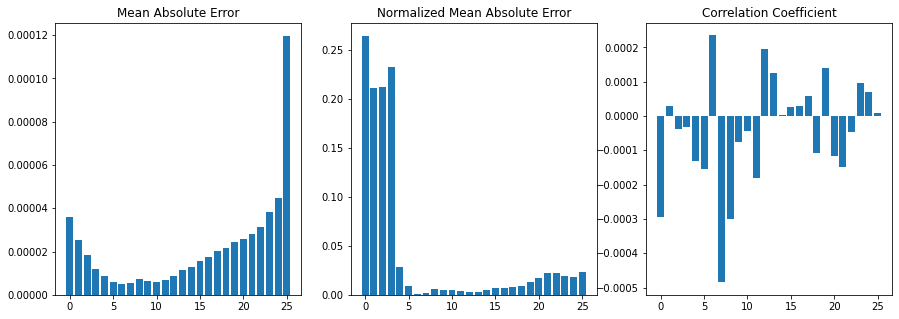

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].bar(np.arange(26), non_mae)
axs[0].set_title("Mean Absolute Error")
axs[1].bar(np.arange(26), nmae)
axs[1].set_title("Normalized Mean Absolute Error")
axs[2].bar(np.arange(26), r)
axs[2].set_title("Correlation Coefficient")
plt.savefig("../../notebooks/plots/sfnp_test_metrics.jpg")
plt.show()

In [9]:
# Make prediction on every value including context
day, hour, idx = 5, 10, 2

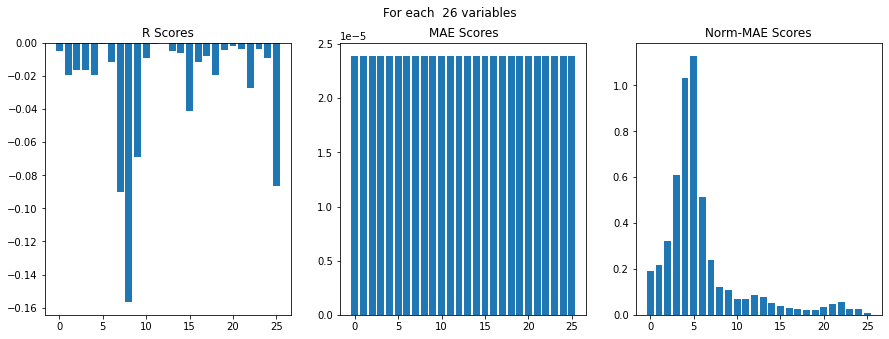

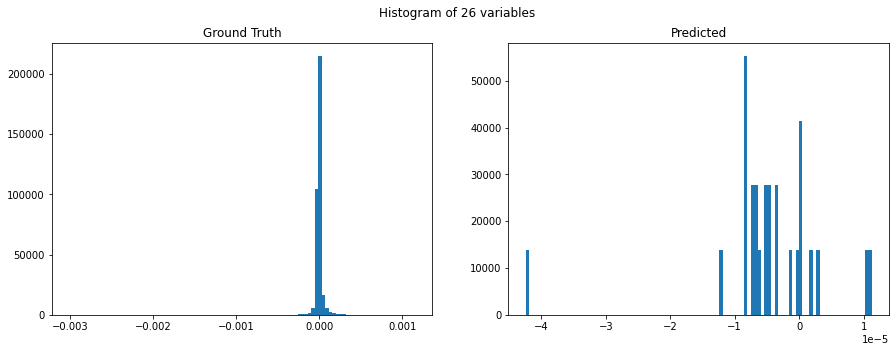

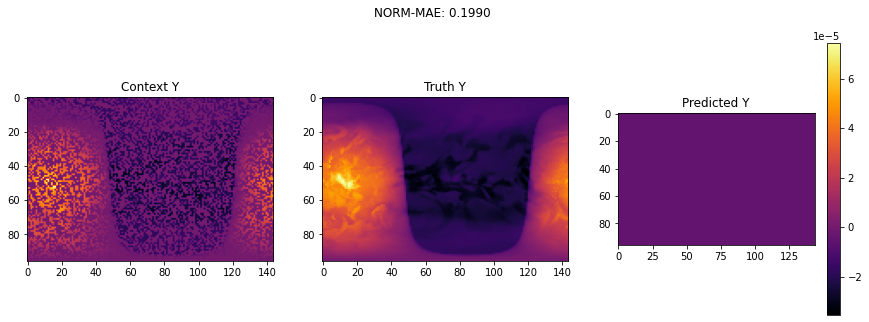

In [10]:
non_y, non_y_context, non_y_pred, context_idxs, target_idxs = evaluator.plot_scenario(day=day, hour=hour, split="test")

non_mae = mae_metric(non_y_pred, non_y, mean=True)
R_scores = []
vars = np.arange(26)
for i in vars:
    R_scores.append(r2_score(non_y[:, i], non_y_pred[:, i]))
norm_mae = non_mae / np.abs(non_y).max(0)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].bar(vars, R_scores)
axs[0].set_title("R Scores")
axs[1].bar(vars, non_mae)
axs[1].set_title("MAE Scores")
axs[2].bar(vars, norm_mae)
axs[2].set_title("Norm-MAE Scores")
plt.suptitle("For each  26 variables")
plt.savefig(f"../../notebooks/plots/sfnp_test_metrics_{day}D_{hour}H.jpg")
plt.show()

fig, axs= plt.subplots(1, 2, figsize=(15, 5))
axs[0].hist(non_y.flatten(), bins=100)
axs[0].set_title("Ground Truth")
axs[1].hist(non_y_pred.flatten(), bins=100)
axs[1].set_title("Predicted")
plt.suptitle("Histogram of 26 variables")
plt.savefig(f"../../notebooks/plots/sfnp_test_hist_{day}D_{hour}H.jpg")
plt.show()


contexts = np.zeros_like(non_y)
contexts[context_idxs] = non_y_context

non_y_img = non_y.reshape(96, 144, -1)[:, :, idx]
vmin = non_y_img.min()
vmax = non_y_img.max()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
plt.set_cmap("inferno")

axs[0].imshow(contexts.reshape(96, 144, -1)[:, :, idx], vmin=vmin, vmax=vmax)
axs[0].set_title("Context Y")
axs[1].imshow(non_y_img, vmin=vmin, vmax=vmax)
axs[1].set_title("Truth Y")
pred_img = axs[2].imshow(non_y_pred.reshape(96, 144, -1)[:, :, idx], vmin=vmin, vmax=vmax)
axs[2].set_title("Predicted Y")
fig.colorbar(pred_img, ax=axs[2])

plt.suptitle(f"NORM-MAE: {norm_mae.mean():.4f}")
plt.savefig(f"../../notebooks/plots/sfnp_test_{day}D_{hour}H_{idx}V.jpg")
plt.show()

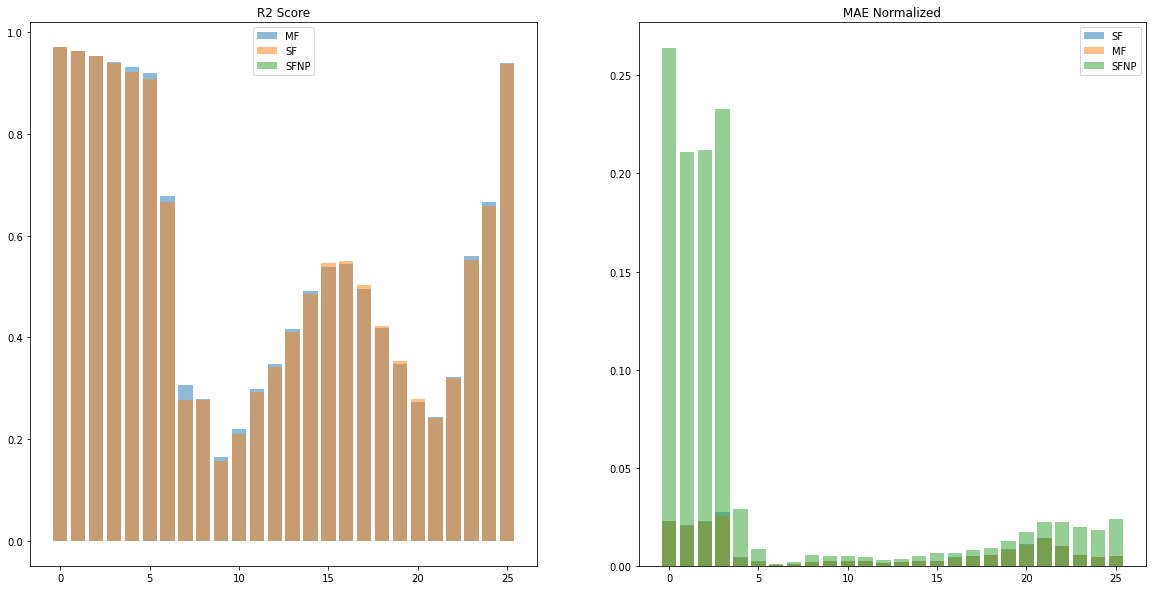

In [24]:
mf_mae = np.load("../../notebooks/aziz_metrics/MAE_MF.npy")
sf_mae = np.load("../../notebooks/aziz_metrics/MAE_SF.npy")
max_y = np.load("../../notebooks/aziz_metrics/max_abs_yH.npy")
mf_r = np.load("../../notebooks/aziz_metrics/r2_MF.npy")
sf_r = np.load("../../notebooks/aziz_metrics/r2_SF.npy")


non_mae = np.load("../../notebooks/metrics/MAE_SFNP.npy")
nmae = np.load("../../notebooks/metrics/NMAE_SFNP.npy")
r = np.load("../../notebooks/metrics/r2_SFNP.npy")

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
n = np.arange(26)
axs[0].bar(n, mf_r, alpha=0.5, label="MF")
axs[0].bar(n, sf_r, alpha=0.5, label="SF")
axs[0].bar(n, r, alpha=0.5, label="SFNP")
axs[0].legend()
axs[0].set_title("R2 Score")

axs[1].bar(n, sf_mae, alpha=0.5, label="SF")
axs[1].bar(n, mf_mae, alpha=0.5, label="MF")
axs[1].bar(n, nmae, alpha=0.5, label="SFNP")
axs[1].legend(loc="upper right")
axs[1].set_title("MAE Normalized")
plt.show()